This notebook is a *heavily* adapted version of https://github.com/habi/EAWAG/blob/main/DataWrangling.ipynb, specifically for the talk at the Institute seminar in 2024.

In [1]:
# Load the python modules we need
import platform
import os
import glob
import pandas
import imageio
import numpy
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn
import dask
import dask_image.imread
from dask.distributed import Client, LocalCluster
import skimage
from tqdm import notebook

In [2]:
# Load our own log file parsing code
from BrukerSkyScanLogfileRuminator.parsing_functions import *

In [3]:
# Set dask temporary folder
# Do this before creating a client: https://stackoverflow.com/a/62804525/323100
import tempfile
if 'Linux' in platform.system():
    # Check if me mounted the FastSSD, otherwise go to standard tmp file
    if os.path.exists(os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')):
        tmp = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD', 'tmp')
    else:
        tmp = tempfile.gettempdir()
elif 'Darwin' in platform.system():
    tmp = tempfile.gettempdir()
else:
    if 'anaklin' in platform.node():
        tmp = os.path.join('F:\\tmp')
    else:
        tmp = os.path.join('D:\\tmp')
dask.config.set({'temporary_directory': tmp})
print('Dask temporary files go to %s' % dask.config.get('temporary_directory'))

Dask temporary files go to /media/habi/Fast_SSD/tmp


In [4]:
from dask.distributed import Client
client = Client()

/home/habi/miniconda3/envs/seminar24/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39123 instead
  warnings.warn(


In [5]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:39123/status,
Dashboard: http://127.0.0.1:39123/status,Workers: 8
Total threads: 32,Total memory: 125.79 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44791,Workers: 8
Dashboard: http://127.0.0.1:39123/status,Total threads: 32
Started: Just now,Total memory: 125.79 GiB
Comm: tcp://127.0.0.1:36587,Total threads: 4
Dashboard: http://127.0.0.1:36327/status,Memory: 15.72 GiB
Nanny: tcp://127.0.0.1:41237,


In [6]:
print('You can see what DASK is doing at "http://localhost:%s/status"' % client.scheduler_info()['services']['dashboard'])

You can see what DASK is doing at "http://localhost:39123/status"


In [7]:
# Set up figure defaults for the talk
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['savefig.transparent'] = True
# Set seaborn theme
seaborn.set_theme(
    context='talk',
    style='whitegrid',
)
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation

In [8]:
Root = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD', 'EAWAG')
print('We are loading all the data from %s' % Root)

We are loading all the data from /media/habi/Fast_SSD/EAWAG


In [9]:
# Make directory for output
# For these notebooks, we simply dump the images one directory up into the relevant 'media' folder
OutPutDir = os.path.join('..', 'media', 'EAWAG')
print('We are saving all the output to %s' % OutPutDir)
os.makedirs(OutPutDir, exist_ok=True)

We are saving all the output to ../media/EAWAG


In [61]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [62]:
# Get *all* log files, unsorted but fast
Data['LogFile'] = [os.path.join(root, name)
                   for root, dirs, files in os.walk(Root)
                   for name in files
                   if name.endswith((".log"))]

In [63]:
# Get all folders
Data['Folder'] = [os.path.dirname(f) for f in Data['LogFile']]

In [64]:
# Get rid of all non-rec logfiles
for c, row in Data.iterrows():
    if 'rec' not in row.Folder:
        Data.drop([c], inplace=True)
    elif 'rectmp.log' in row.LogFile:
        Data.drop([c], inplace=True)
# Reset dataframe index
Data = Data.reset_index(drop=True)

In [65]:
# Generate us some meaningful colums
Data['Fish'] = [l[len(Root) + 1:].split(os.sep)[0] for l in Data['LogFile']]
Data['Scan'] = ['.'.join(l[len(Root) + 1:].split(os.sep)[1:-1]) for l in Data['LogFile']]

In [66]:
# Get parameters related to scan from logfiles
Data['Voxelsize'] = [pixelsize(log) for log in Data['LogFile']]
Data['Voltage'] = [voltage(log) for log in Data['LogFile']]
Data['Current'] = [current(log) for log in Data['LogFile']]
Data['Filter'] = [whichfilter(log) for log in Data['LogFile']]
Data['Exposuretime'] = [exposuretime(log) for log in Data['LogFile']]
Data['Scanner'] = [scanner(log) for log in Data['LogFile']]
Data['Averaging'] = [averaging(log) for log in Data['LogFile']]
Data['Scan date'] = [scandate(log) for log in Data['LogFile']]
Data['ProjectionSize'] = [projection_size(log) for log in Data['LogFile']]
Data['RotationStep'] = [rotationstep(log) for log in Data['LogFile']]
Data['ThreeSixty'] = [threesixtyscan(log) for log in Data['LogFile']]

In [67]:
Data['Voxelsize'].unique()

array([ 13.120329,   7.514115,   2.999931,   7.991271,  26.001323,
         5.000018,  11.998662,   5.999331,   5.499452,   8.88045 ,
        28.000837,  11.92668 ,  29.000594,   4.000007,  24.999263,
         6.799137,   8.110939,  22.999021,   5.000014,  13.001449,
        17.999448,   6.750664,  19.999749,   5.962976,   7.036958,
        11.999389,  12.499268,   7.000603,   7.75345 ,   8.468428,
         7.633783,  21.999992,   8.34876 ,  15.500842,   4.50002 ,
        16.00072 ,   6.500724,  17.499569,  33.000351,   8.00036 ,
         5.367666,   8.500239,  16.99969 ,   9.003147,  15.898443,
         9.999875,   8.588096,  10.999632,  20.000477,  10.13772 ,
         9.422742,  30.000352,   8.230607,   7.750421,  34.999138,
        10.734545,   9.000117,   9.997818,   6.998517,  15.999933,
         7.500482,   6.559801,  14.501084,  11.33137 ,  30.200303,
         7.156626,  35.998895,  16.697521,  24.998536,  14.001206,
         8.945585,  18.999992,  21.614722,  24.498657,   8.300

In [68]:
# Get parameters related to reconstruction from logfiles
Data['ReconstructionSize'] = [reconstruction_size(log) for log in Data['LogFile']]
Data['Grayvalue'] = [reconstruction_grayvalue(log) for log in Data['LogFile']]
Data['RingartefactCorrection'] = [ringremoval(log) for log in Data['LogFile']]
Data['BeamHardeningCorrection'] = [beamhardening(log) for log in Data['LogFile']]
Data['ROI'] = [region_of_interest(log) for log in Data['LogFile']]
Data['Duration'] = [duration(log) for log in Data['LogFile']]
Data['Stacks'] = [stacks(log) for log in Data['LogFile']]

In [69]:
# The iee research storage folder contains some folders with scans done by Kassandra on a SkyScan1273.
# Exclude those, since they are not part of this study, we just looked at them to help her.
for c, row in Data.iterrows():
    if '1273' in row.Scanner:
        # print('Dropping %s from our dataframe' % row.LogFile[len(Root)+1:])
        Data.drop([c], inplace=True)
# Reset dataframe index
Data = Data.reset_index(drop=True)

In [70]:
# The iee research storage folder contains folders with scans of only teeth, done as a small pilot study.
# Exclude those, since they are not part of this study.
for c, row in Data.iterrows():
    if 'Teeth' in row.Folder:
        # print('Dropping %s from our dataframe' % row.LogFile[len(Root)+1:])
        Data.drop([c], inplace=True)
# Reset dataframe index
Data = Data.reset_index(drop=True)

In [71]:
# Sort dataframe on fishes and scans
Data.sort_values(by=['Fish', 'Scan'], inplace=True)
# Reset dataframe index
Data = Data.reset_index(drop=True)

In [72]:
# How many fishes did we scan?
# We scanned six 'BucketOfFish' so subtract those :)
print('We have %s unique names in our corpus of scans' % (len(Data.Fish.unique()) - 6))
print('We performed %s scans in total' % len(Data.Scan))

We have 137 unique names in our corpus of scans
We performed 396 scans in total


In [73]:
Data['Total Duration'] = [st * stk for st, stk in zip(Data['Duration'], Data['Stacks'])]

In [74]:
# Get an overview of the total scanning time
# Nice output based on https://stackoverflow.com/a/8907407/323100
total_seconds = int(Data['Total Duration'].sum())
hours, remainder = divmod(total_seconds, 60 * 60)
minutes, seconds = divmod(remainder, 60)
print('In total, we scanned for %s hours and %s minutes' % (hours, minutes))
for machine in Data['Scanner'].unique():
    total_seconds = int(Data[Data['Scanner'] == machine]['Total Duration'].sum())
    hours, remainder = divmod(total_seconds, 60 * 60)
    minutes, seconds = divmod(remainder, 60)
    print('\t - Of these, we scanned %s hours and %s minutes on the %s,'
          ' for %s scans' % (hours,
                             minutes,
                             machine,
                             len(Data[Data['Scanner'] == machine])))

In total, we scanned for 1162 hours and 36 minutes
	 - Of these, we scanned 898 hours and 34 minutes on the SkyScan 2214, for 358 scans
	 - Of these, we scanned 264 hours and 1 minutes on the SkyScan 1272, for 38 scans


In [75]:
# We scanned six 'buckets of fish', so subtract those :)
print('We scanned %0.f fishes' % (len(Data.Fish.unique()) - 6))

We scanned 137 fishes


In [76]:
print('We did a total of %s scans' % len(Data))

We did a total of 396 scans


In [77]:
print('We perfomed %s scans with "head" in their folder name' % len(Data[Data['Scan'].str.contains('head')]))

We perfomed 110 scans with "head" in their folder name


In [78]:
# for c, st in enumerate(['darkgrid',
#                         'whitegrid',
#                         'dark',
#                         'white',
#                         'ticks']):
#     seaborn.set_style(style=st)    
#     seaborn.boxenplot(Data.Voxelsize, color='#E6002E')
#     plt.ylim([0,50])
#     plt.title(st)   
#     plt.show()

In [79]:
MikkisFile = sorted(glob.glob(os.path.join(Root, '*CTscanFishList.xlsx')))[0]
# Read excel file and use the first column as index
print('Reading in %s' % MikkisFile)
DataMikki = pandas.read_excel(MikkisFile)

Reading in /media/habi/Fast_SSD/EAWAG/2022.03.26_CTscanFishList.xlsx


In [80]:
for i in DataMikki:
    print(i)

Fishec
FieldID
OtherID
ReplacementID
FishID_ColourScanStatus
Length(cm)
TemporaryJar
Genus
Species
Ecology
Replicates
Scan date
HeadScan
OralJawScan
UpperOralJaw
LowerOralJaw
PharyngealJawScan
UpperPharyngealJaw
LowerPharyngealJaw
ScanComments
QualityChecked
Unnamed: 21
SpecimenReturned
Comments


In [81]:
DataMikki['Length(cm)'].unique()

array([nan, '< 7', 8, 9.5, '?', 11, 12.5, 13.5, 10, 12, 14, 15.5, 7.5,
       10.5, 17, 13, 11.5, 8.5, 6, 7, 15, 16, 18, 'measure SL', 14.5, 9,
       6.2, 6.5, 7.9, '< 6', 'LE < 7'], dtype=object)

In [82]:
# Massage some values, so we can plot *all* values nicely
DataMikki['Length(cm)'].replace('?', numpy.nan, inplace=True)
DataMikki['Length(cm)'].replace('measure SL', numpy.nan, inplace=True)
DataMikki['Length(cm)'].replace('< 6', 5.5, inplace=True)
DataMikki['Length(cm)'].replace('< 7', 6.5, inplace=True)
DataMikki['Length(cm)'].replace('LE < 7', 6.5, inplace=True)

/tmp/ipykernel_1806684/3028068595.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  DataMikki['Length(cm)'].replace('?', numpy.nan, inplace=True)
/tmp/ipykernel_1806684/3028068595.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, i

In [83]:
sorted(DataMikki['Length(cm)'].unique())

[np.float64(nan),
 np.float64(5.5),
 np.float64(6.0),
 np.float64(6.2),
 np.float64(6.5),
 np.float64(7.0),
 np.float64(7.5),
 np.float64(7.9),
 np.float64(8.0),
 np.float64(8.5),
 np.float64(9.0),
 np.float64(9.5),
 np.float64(10.0),
 np.float64(10.5),
 np.float64(11.0),
 np.float64(11.5),
 np.float64(12.0),
 np.float64(12.5),
 np.float64(13.0),
 np.float64(13.5),
 np.float64(14.0),
 np.float64(14.5),
 np.float64(15.0),
 np.float64(15.5),
 np.float64(16.0),
 np.float64(17.0),
 np.float64(18.0)]

Plot the length of all the fish, so we can 'visualize' them for the audience.
In one of the last seminars, a discussion sprung up about violin plots, so we deliberately show them here again :)

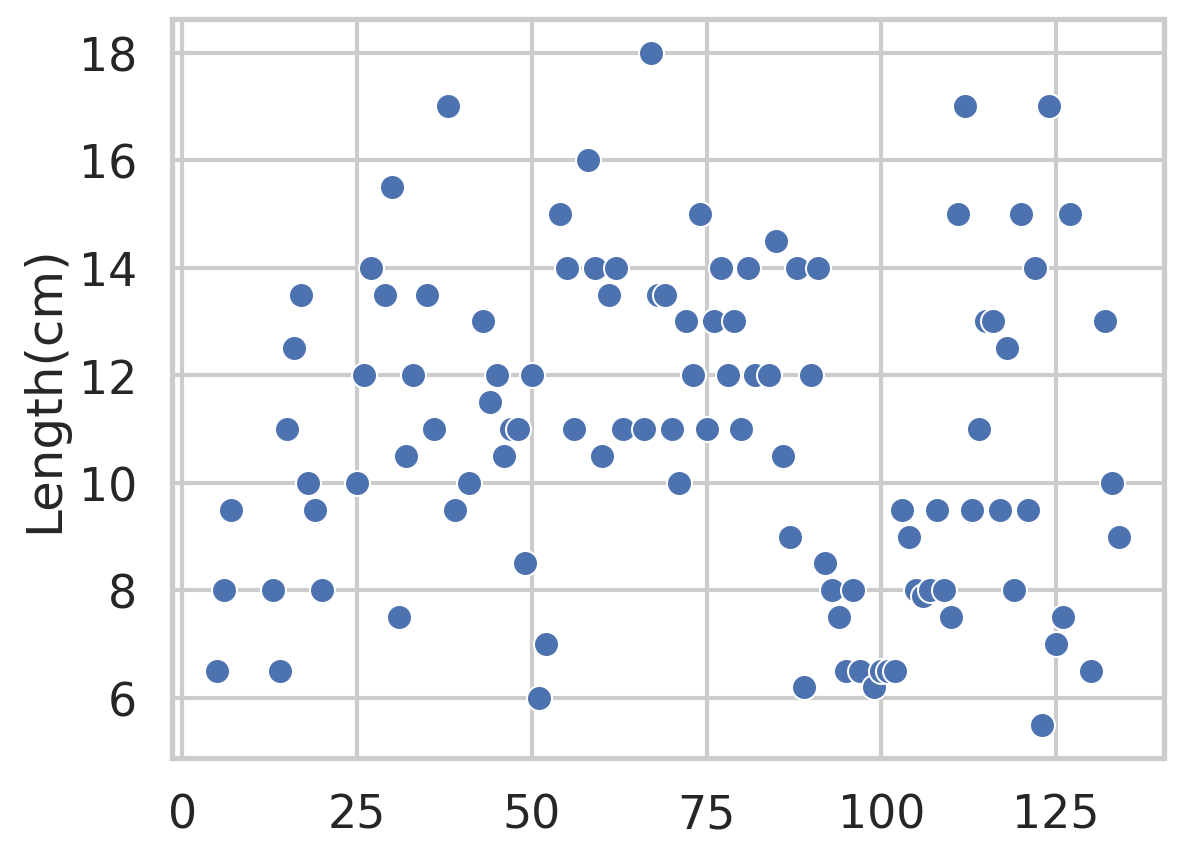

In [84]:
# Plot fish lengths
seaborn.scatterplot(DataMikki['Length(cm)'])
plt.show()

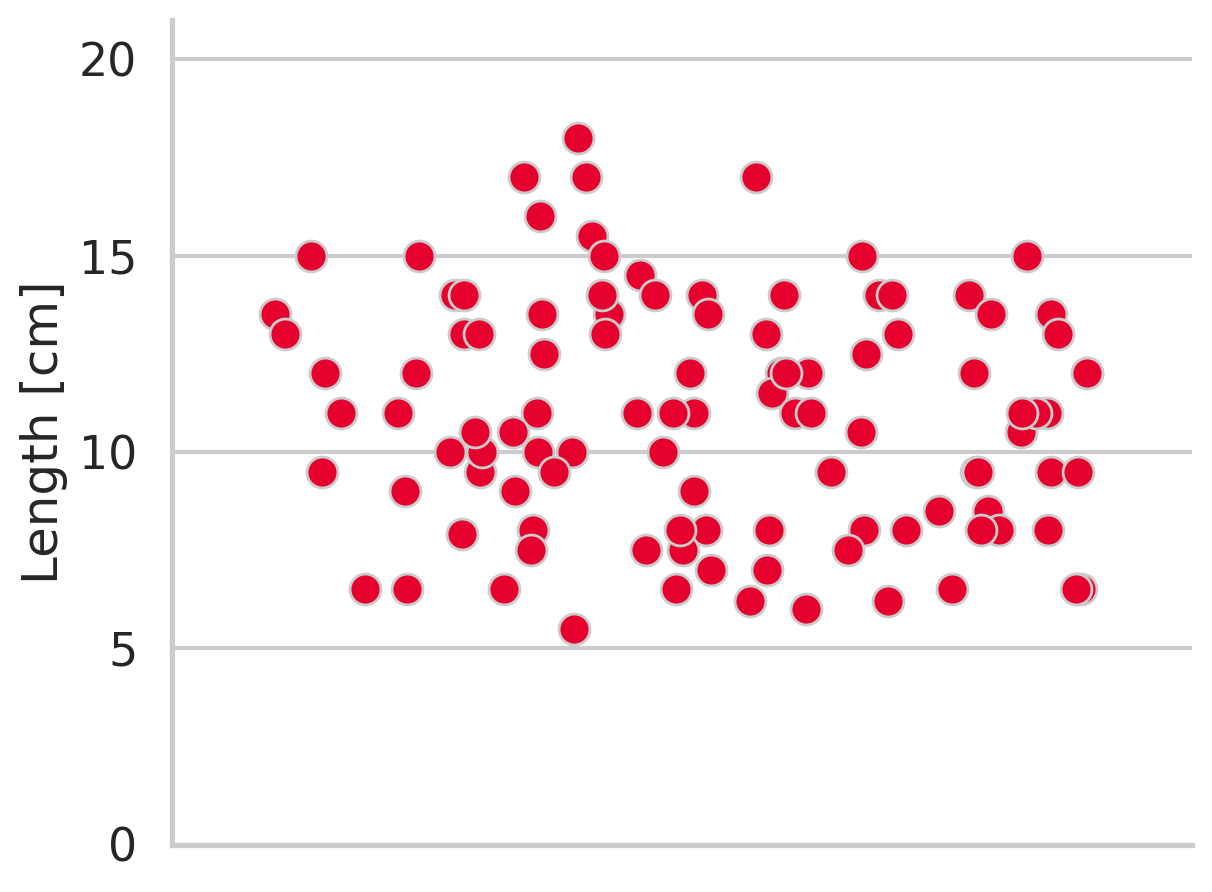

In [85]:
# Plot fish lengths
numpy.random.seed(1796)
seaborn.stripplot(DataMikki['Length(cm)'],
                  color='#E6002E',
                  size=plt.gca().yaxis.label.get_fontsize() * 0.618,
                  linewidth=1,
                  edgecolor='#cccccc',
                  jitter=0.8/2)
plt.ylim([0,21])
plt.ylabel('Length [cm]')
seaborn.despine()
plt.tight_layout()
plt.savefig(os.path.join(OutPutDir, 'lengths.plot.png'))

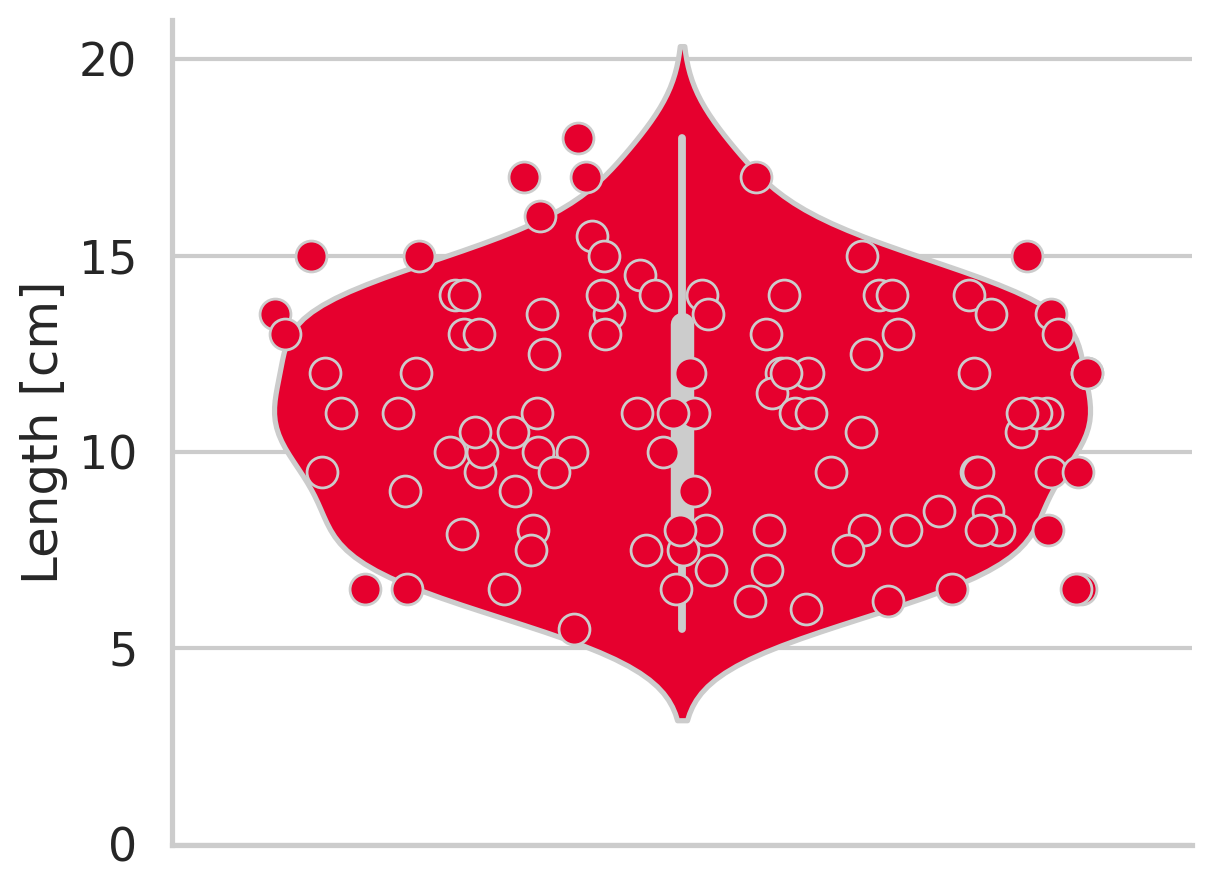

In [87]:
# Plot fish lengths
numpy.random.seed(1796)
seaborn.stripplot(DataMikki['Length(cm)'],
                  color='#E6002E',
                  size=plt.gca().yaxis.label.get_fontsize() * 0.618,
                  linewidth=1,
                  edgecolor='#cccccc',
                  jitter=0.8/2)
seaborn.violinplot(DataMikki['Length(cm)'],
                   color='#E6002E',
                   edgecolor='#cccccc',
                   width=0.8,
                   saturation=1)
plt.ylim([0,21])
plt.ylabel('Length [cm]')
seaborn.despine()
plt.tight_layout()
plt.savefig(os.path.join(OutPutDir, 'lengths.violinplot.png'))

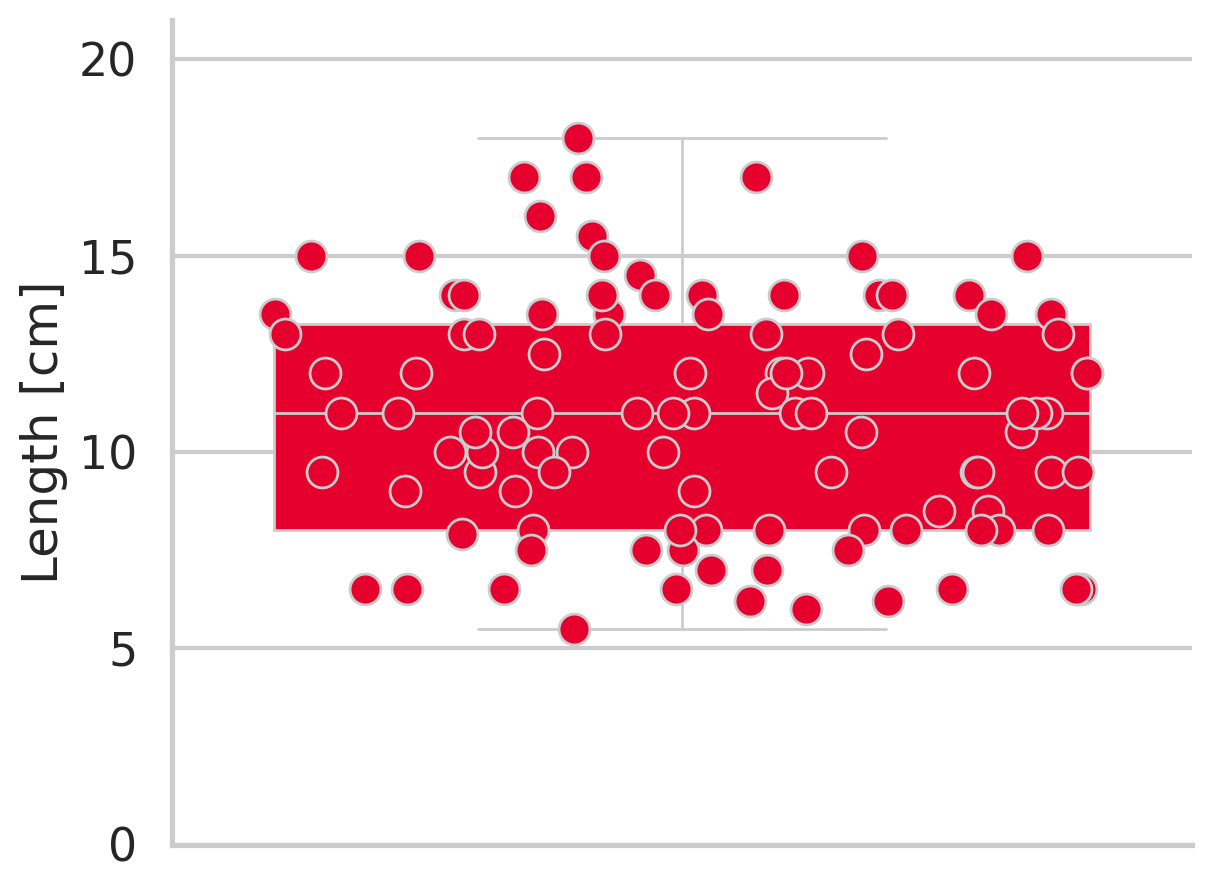

In [90]:
# Plot fish lengths
numpy.random.seed(1796)
seaborn.stripplot(DataMikki['Length(cm)'],
                  color='#E6002E',
                  size=plt.gca().yaxis.label.get_fontsize() * 0.618,
                  linewidth=1,
                  edgecolor='#cccccc',
                  jitter=0.8/2)
seaborn.boxplot(DataMikki['Length(cm)'],
                color='#E6002E',
                linecolor='#cccccc',
                saturation=1)
plt.ylim([0, 21])
plt.ylabel('Length [cm]')
seaborn.despine()
plt.tight_layout()
plt.savefig(os.path.join(OutPutDir, 'lengths.boxplot.png'))

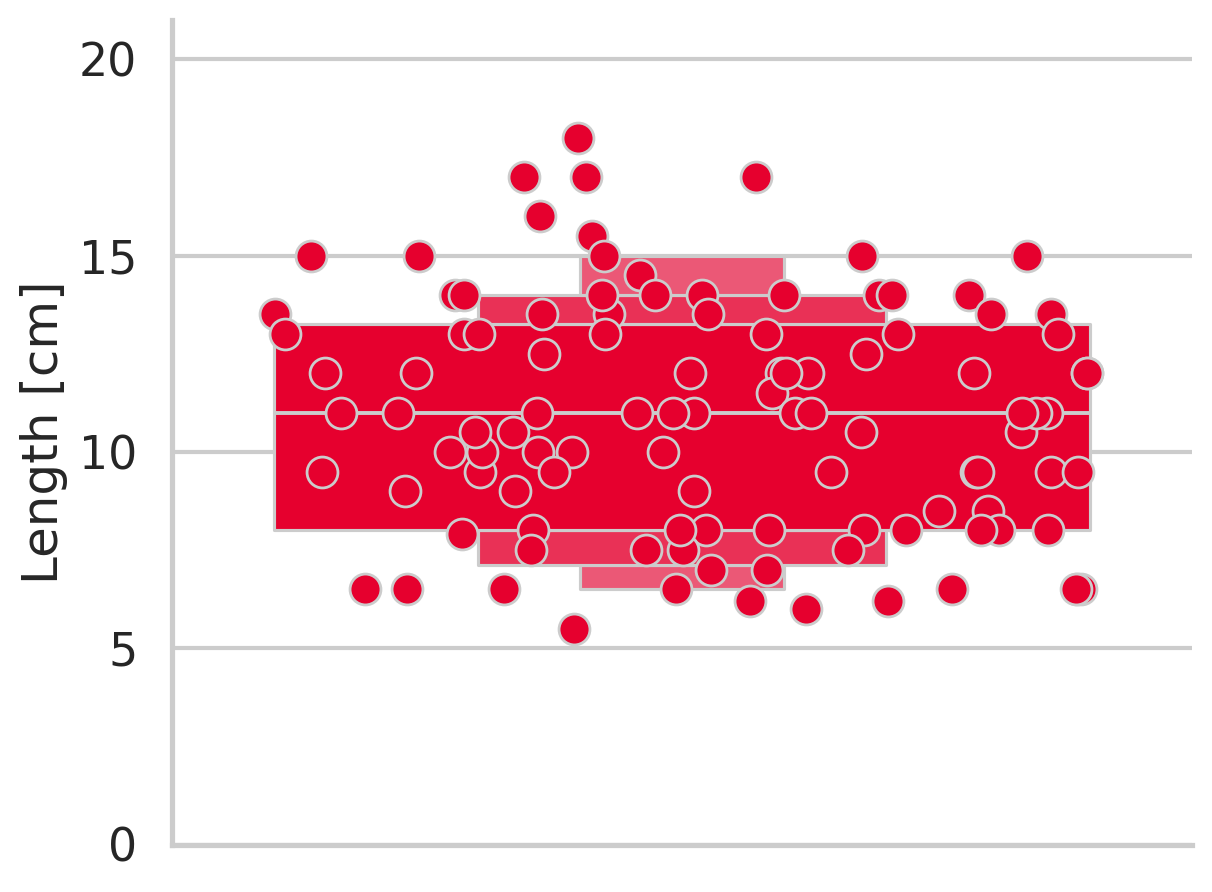

In [91]:
# Plot fish lengths
numpy.random.seed(1796)
seaborn.stripplot(DataMikki['Length(cm)'],
                  color='#E6002E',
                  size=plt.gca().yaxis.label.get_fontsize() * 0.618,
                  linewidth=1,
                  edgecolor='#cccccc',
                  jitter=0.8/2)
seaborn.boxenplot(DataMikki['Length(cm)'],
                  color='#E6002E',
                  edgecolor='#cccccc',
                  line_kws=dict(color="#cccccc"),
                  saturation=1, showfliers=False)
plt.ylim([0, 21])
plt.ylabel('Length [cm]')
seaborn.despine()
plt.tight_layout()
plt.savefig(os.path.join(OutPutDir, 'lengths.boxenplot.png'))
plt.show()

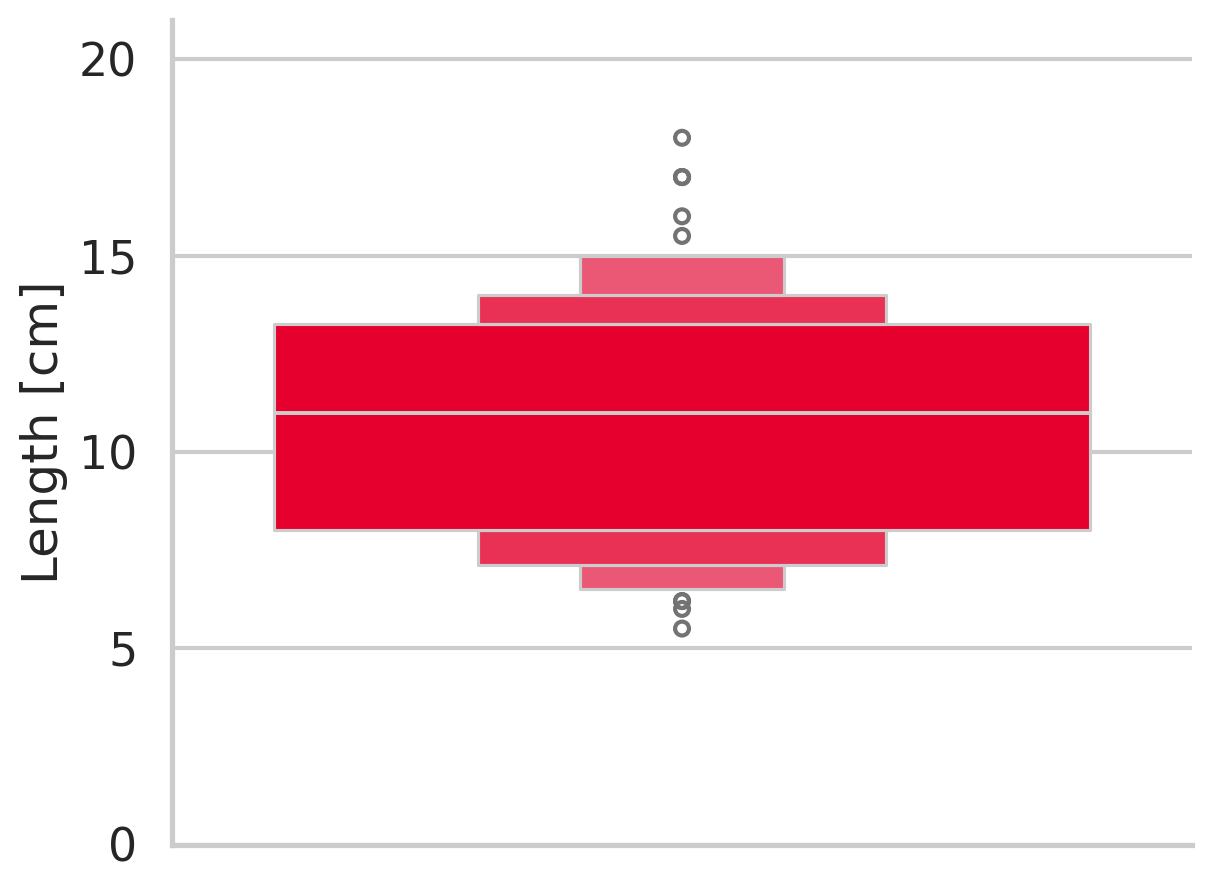

In [92]:
# Plot fish lengths
seaborn.boxenplot(DataMikki['Length(cm)'],
                  color='#E6002E',
                  edgecolor='#cccccc',
                  line_kws=dict(color="#cccccc"),
                  saturation=1)
plt.ylim([0, 21])
plt.ylabel('Length [cm]')
seaborn.despine()
plt.tight_layout()
plt.savefig(os.path.join(OutPutDir, 'lengths.boxenplot.only.png'))
plt.show()

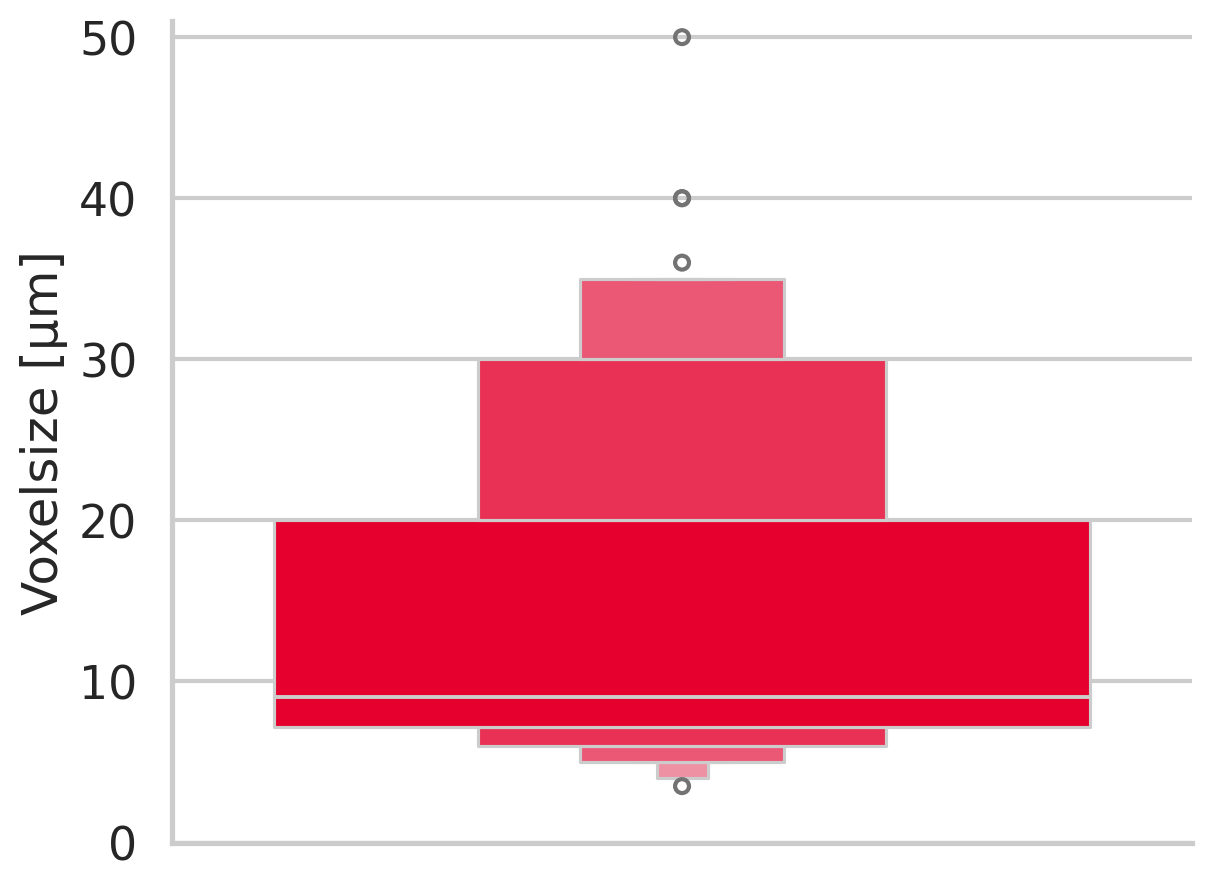

In [95]:
# Plot scan voxel size
seaborn.boxenplot(Data['Voxelsize'],
                  color='#E6002E',
                  edgecolor='#cccccc',
                  line_kws=dict(color="#cccccc"),
                  saturation=1)
plt.ylabel('Voxelsize [μm]')
plt.ylim([0, 51])
seaborn.despine()
plt.tight_layout()
plt.savefig(os.path.join(OutPutDir, 'voxelsizes.png'))
plt.show()

In [40]:
# Let's only talk about one fish
fish = '104016'

In [41]:
# Get rid of all other fish, so we can easily see what we talk about
for c, row in Data.iterrows():
    if fish not in row.Fish:
        Data.drop([c], inplace=True)
Data = Data.reset_index(drop=True)

In [42]:
# Data[Data.isin([fish])]
Data

,LogFile,Folder,Fish,Scan,Voxelsize,Voltage,Current,Filter,Exposuretime,Scanner,...,RotationStep,ThreeSixty,ReconstructionSize,Grayvalue,RingartefactCorrection,BeamHardeningCorrection,ROI,Duration,Stacks,Total Duration
0,/media/habi/Fast_SSD/EAWAG/104016/head/rec/104...,/media/habi/Fast_SSD/EAWAG/104016/head/rec,104016,head.rec,13.001449,70.0,137.0,False,740,SkyScan 2214,...,0.2,False,"(1488, 864)",0.066326,NaN,NaN,"(1187, 322, 23, 1514)",2359.0,3,7077.0
1,/media/habi/Fast_SSD/EAWAG/104016/jaw/rec/1040...,/media/habi/Fast_SSD/EAWAG/104016/jaw/rec,104016,jaw.rec,5.000014,60.0,166.0,Al 0.25mm,1878,SkyScan 1272,...,0.2,False,"(2152, 1388)",0.249223,19.0,NaN,"(2415, 1026, 280, 2435)",6666.0,1,6666.0
2,/media/habi/Fast_SSD/EAWAG/104016/pharynx/rec/...,/media/habi/Fast_SSD/EAWAG/104016/pharynx/rec,104016,pharynx.rec,5.000014,60.0,166.0,Al 0.25mm,1500,SkyScan 1272,...,0.2,False,"(2452, 2452)",0.225172,19.0,NaN,False,7097.0,1,7097.0


In [43]:
    # In which jar should it be/go?
    foundfishes = 0
    for d, row in DataMikki.iterrows():
        if (str(fish).lower() in str(row.Fishec).lower()) \
        or (str(fish).lower() in str(row.FieldID).lower()) \
        or (str(fish).lower() in str(row.OtherID).lower()) \
        or (str(fish).lower() in str(row.ReplacementID).lower()):
            foundfishes = (row.Fishec, row.FieldID, row.OtherID, row.ReplacementID)
            # remove nan from the list of hits
            foundfishes = [str(x).lower() for x in foundfishes if not pandas.isnull(x)]
            print('*%s*: The fish ' % fish, end='')
            if len(foundfishes) > 1:
                for found in foundfishes:
                    print(found.upper(), end='/')
            else:
                print(foundfishes[0].upper(), end='')
            print(' should now go in jar "length=%s cm" (%s))' % (row['Length(cm)'],
                                                                  row['TemporaryJar']))
    if not foundfishes:
        print('*%s*: Nothing found in %s' % (fish, MikkisFile))

*104016*: The fish 104016 should now go in jar "length=6.5 cm" (< 7cm))


In [44]:
    # Do we have something from this fish on disk?
    ondisk = glob.glob(os.path.join(Root, '*%s*' % fish))
    if len(ondisk):
        for found in ondisk:
            print('*%s*: Found on disk in %s' % (fish, found))
            foundondisk = 1
    else:
        print('*%s*: Nothing found in %s' % (fish, Root))
        foundondisk = 0

*104016*: Found on disk in /media/habi/Fast_SSD/EAWAG/104016


In [45]:
    # Did we scan it already?
    found = 0
    for c, row in Data.iterrows():
        if fish in row.Fish:
            print('*%s*: Sample %s/%s was scanned on %s' % (fish, row['Fish'], row['Scan'], row['Scan date']))
            found = 1
    if not found:
        if foundondisk:
            print('*%s*: We have a folder (%s) for this sample, but nothing in the dataframe, so it probably is all good' % (fish, ondisk[0]))
            print('Check the folder to be shure')
        else:
            print('*%s*: Nothing about this sample is found in our dataframe' % fish)

*104016*: Sample 104016/head.rec was scanned on 2022-01-27 13:32:59
*104016*: Sample 104016/jaw.rec was scanned on 2021-02-04 11:21:23
*104016*: Sample 104016/pharynx.rec was scanned on 2021-02-04 13:30:11
